In [2]:
import numpy as np
import pandas as pd
import pyflux as pf
import warnings

from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
db_path = "../data/processed/shuffled.csv"
cols = ['Pickup_longitude', 'Pickup_latitude',
          'Dropoff_longitude', 'Dropoff_latitude'
         ]
df0 = pd.read_csv(db_path,nrows=10e6,infer_datetime_format=True,usecols=cols)

In [4]:
# print(df0.columns.values)
print(len(df0))

5000000


## Trim to Manhattan-ish area

In [5]:
# process lat,lon -> grid
#df = df0.copy()df=df0


# df["x0"] = df["Pickup_longitude"].apply(lambda x : int(x*100))
# df["y0"] = df["Pickup_latitude"].apply(lambda x : int(x*100))
# df["x1"] = df["Dropoff_longitude"].apply(lambda x : int(x*100))
# df["y1"] = df["Dropoff_latitude"].apply(lambda x : int(x*100))


df0["x0"] = (100*df0["Pickup_longitude"]).astype(int)
df0["y0"] = (100*df0["Pickup_latitude"]).astype(int)
df0["x1"] = (100*df0["Dropoff_longitude"]).astype(int)
df0["y1"] = (100*df0["Dropoff_latitude"]).astype(int)

df=df0.copy()

df = df.loc[(df["y0"] > 4050) & (df["y0"] < 4090) ]

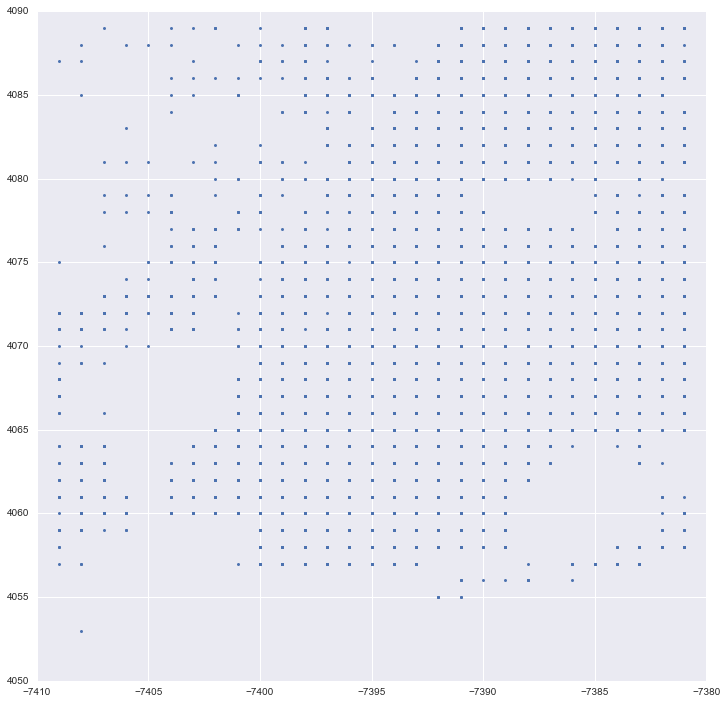

In [6]:
# for c in df["xy0"].value_counts():
df = df.loc[(df["x0"] > -7410) & (df["x0"] < -7380)]
# print(df0["x1"])
plt.figure(figsize=(12,12))
plt.plot(df["x0"],df["y0"],'o',markersize=3)

In [29]:
import geohash

df2 = df.copy()
df2["coord"] = list(zip(df2["Pickup_latitude"],df2["Pickup_longitude"]))
df2["coord"] = df2["coord"].apply(lambda x : geohash.encode(x[0],x[1],6))
df2["coord"] = df2["coord"].apply(geohash.decode)

In [30]:
%time tab = df2["coord"].value_counts()
print(tab)

CPU times: user 12.6 s, sys: 32 ms, total: 12.6 s
Wall time: 12.5 s
(40.74554443359375, -73.8885498046875)    172715
(40.80596923828125, -73.9434814453125)    155784
(40.78948974609375, -73.9544677734375)    120471
(40.69061279296875, -73.9874267578125)    118234
(40.71807861328125, -73.9544677734375)    109958
(40.68511962890625, -73.9764404296875)    108950
(40.81146240234375, -73.9544677734375)     98823
(40.80596923828125, -73.9654541015625)     98704
(40.72357177734375, -73.9544677734375)     85258
(40.72357177734375, -73.8446044921875)     82682
(40.70159912109375, -73.9874267578125)     78349
(40.76751708984375, -73.9215087890625)     74947
(40.71258544921875, -73.9654541015625)     73769
(40.74554443359375, -73.8995361328125)     71910
(40.71258544921875, -73.9544677734375)     71399
(40.80047607421875, -73.9544677734375)     67918
(40.80596923828125, -73.9544677734375)     67205
(40.73455810546875, -73.8665771484375)     66237
(40.80047607421875, -73.9434814453125)     61909
(

In [31]:
len(tab)

1124

In [32]:
# temp["coords"] = temp.index.values
#temp.index = temp.reset_index(drop=True)
df2 = pd.DataFrame(data = tab) #,columns=["count"])
df2["coords"] = df2.index.values
df2 = df2.reset_index(drop=True)

df2 = df2.rename(columns = {"coord" : "count"})
df2["y"] = df2["coords"].apply(lambda x : x[0])
df2["x"] = df2["coords"].apply(lambda x : x[1])

df2 = df2[["x","y","count"]]
# print(df2)
# print(np.array(df2))

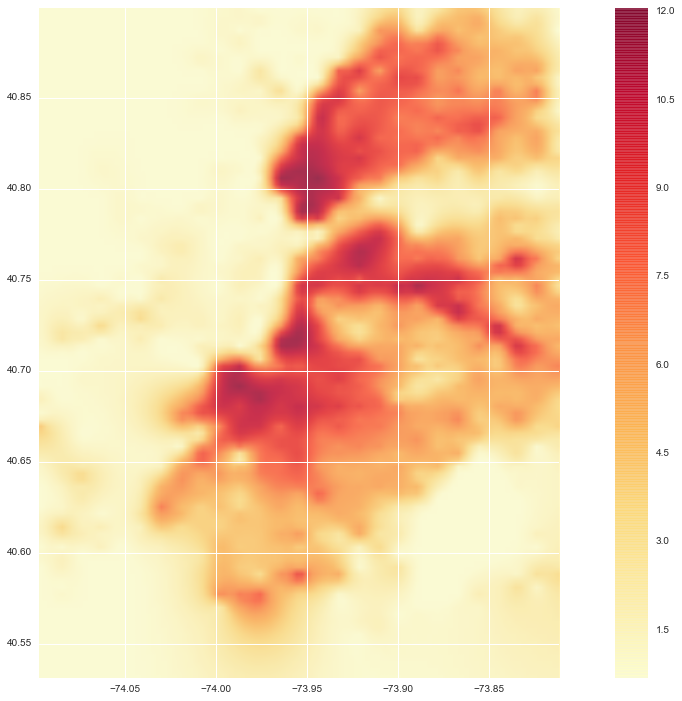

In [33]:
# plt.pcolormesh(df2["x"],df2["y"],df2["count"])
# plt.show()

import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate

# Generate data:
# x, y, z = 10 * np.random.random((3,10))
x = np.array(df2["x"])
y = np.array(df2["y"])
z = np.log1p(np.array(df2["count"]))
# Set up a regular grid of interpolation points
xi, yi = np.linspace(x.min(), x.max(), 100), np.linspace(y.min(), y.max(), 100)
xi, yi = np.meshgrid(xi, yi)

# Interpolate
rbf = scipy.interpolate.Rbf(x, y, z, function='linear')
zi = rbf(xi, yi)
plt.figure(figsize=(20,12))
plt.imshow(zi, vmin=z.min(), vmax=z.max(), origin='lower',
           extent=[x.min(), x.max(), y.min(), y.max()],cmap="YlOrRd",alpha=0.8)
# plt.scatter(x, y, c=z)
plt.colorbar()
plt.show()

In [34]:
import json
shapes_path = "../data/external/nyc.geojson"
with open(shapes_path) as f:
    nyc = json.loads(f.read())

In [35]:
d = {}
for i in nyc["features"]:
    key = i["properties"]["neighborhood"]
    xs = []
    ys = []
    coords = {}
    for c in i["geometry"]["coordinates"][0]:
        coords = c
        xs += [c[0]]
        ys += [c[1]]
    
    d[key] = {"xs" : xs, "ys" : ys}

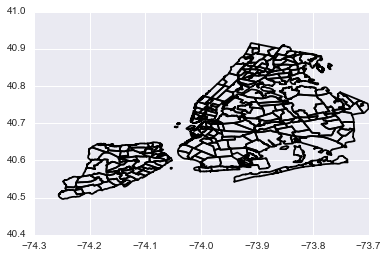

In [36]:
for hood in d.keys():
    plt.plot(d[hood]["xs"],d[hood]["ys"],color="k")

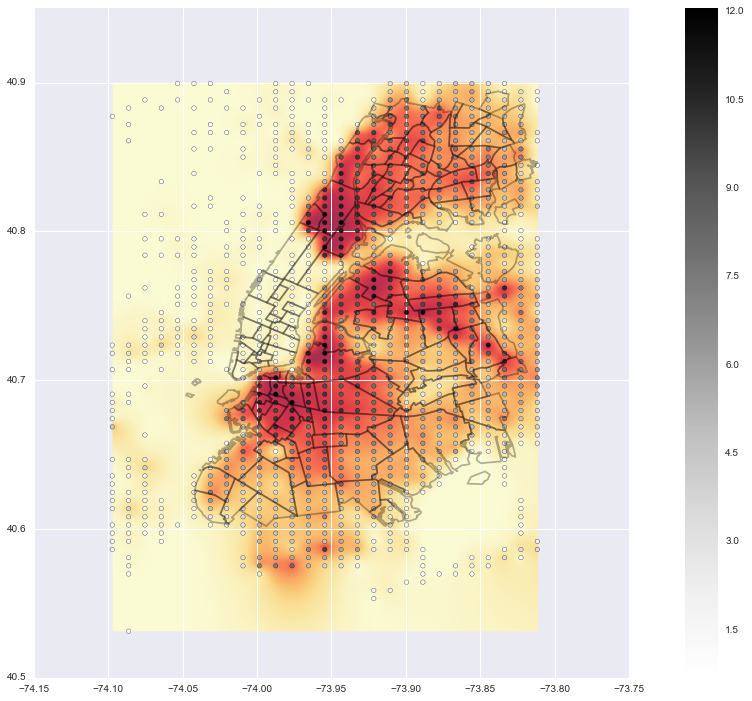

In [37]:
# plt.pcolormesh(df2["x"],df2["y"],df2["count"])
# plt.show()

import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate

# Generate data:
# x, y, z = 10 * np.random.random((3,10))
x = np.array(df2["x"])
y = np.array(df2["y"])

z = np.log1p(np.array(df2["count"]))
# Set up a regular grid of interpolation points
xi, yi = np.linspace(x.min(), x.max(), 100), np.linspace(y.min(), y.max(), 100)
xi, yi = np.meshgrid(xi, yi)

# Interpolate
rbf = scipy.interpolate.Rbf(x, y, z, function='linear')
zi = rbf(xi, yi)
plt.figure(figsize=(20,12))
plt.imshow(zi, vmin=z.min(), vmax=z.max(), origin='lower',
           extent=[x.min(), x.max(), y.min(), y.max()],cmap="YlOrRd",alpha=0.8)

for hood in d.keys():
    if (np.amin(d[hood]["xs"]) > -74.05) and (np.amax(d[hood]["xs"]) < -73.81)  \
    and (np.amax(d[hood]["ys"]) < 40.9) and (np.amin(d[hood]["ys"]) > 40.6):
        plt.plot(d[hood]["xs"],d[hood]["ys"],color="k",alpha=0.3)
plt.scatter(x, y, c=z)
plt.colorbar()
plt.show()

In [38]:
len(df2.loc[df2["count"]>100])

599